# Vision por Computadora II - CEIA

### Trabajo Final

Autor: Karen Raczkowski

En el siguiente trabajo se busca clasificar imágenes de diferentes razas de perros utilizando redes neuronales.

Objetivo: identificar la raza de perros en imágenes.<br>
Problema: clasificación multiclase.<br>
Cantidad de clases: 120<br>
Nombre de las clases: nombres de 120 razas de perros, por ejemplo, 'Pekinese', 'Labrador', 'Bulldog', etc.<br>
Total de imágenes del dataset: 20,580<br>
División Train-Test: 80-20%<br>
Arquitecturas de modelos: ResNet18, ResNet50, VGG19<br>
Visualización GradCAM

In [90]:
import random
import os
import platform
import sys
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f

In [91]:
if 'google.colab' in sys.modules:
    !pip install torchmetrics
    !pip install --upgrade --no-cache-dir gdown
    import gdown

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Descargar el dataset

In [92]:
# Correr solo si es necesario descargar el dataset
import requests

def download_file_from_onedrive(url, destination):
    response = requests.get(url, allow_redirects=True)
    if response.status_code == 200:
        with open(destination, 'wb') as file:
            file.write(response.content)
    else:
        print(f"Error al descargar el archivo: {response.status_code}")

# Enlace de descarga directa de OneDrive
onedrive_link = "https://onedrive.live.com/download.aspx?authkey=%21AERlgCBx8y6ZrOU&resid=75263E3DFDFB225E%2165439&cid=75263E3DFDFB225E&parId=root&parQt=sharedby&parCid=UnAuth&o=OneUp"

# Ruta de destino donde quieres guardar el archivo
destination_file = "Stanford_Dogs_Dataset.zip"

# Descargar el archivo
download_file_from_onedrive(onedrive_link, destination_file)

print(f"Archivo descargado en: {destination_file}")

Archivo descargado en: Stanford_Dogs_Dataset.zip


In [93]:
# Descomprimir
import zipfile

# Función para descomprimir el archivo
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Descomprimir el archivo
unzip_file("Stanford_Dogs_Dataset.zip", "./Stanford_Dogs_Dataset/")

print(f"Archivo descomprimido")

Archivo descomprimido


### Exploración del conjunto de datos

Exploramos el contenido del dataset para obtener una idea más clara de las razas y las imágenes con las que vamos a trabajar.

In [94]:
import glob

# Cargar la lista de nombres de las razas de perros
breeds = [item for item in sorted(glob.glob('./Stanford_Dogs_Dataset/images/Images/*'))]

# Imprimir estadísticas sobre el conjunto de datos
print('Hay un total de %d categorías de razas de perros.' % len(breeds))

# Inicializar un contador para el número total de imágenes
total_images = 0

# Contar el número de imágenes por raza
for breed in breeds:
    # Contar el número de archivos en el directorio de cada raza
    num_images = len(glob.glob(breed + '/*'))
    total_images += num_images

print('Hay un total de %d imágenes de perros.' % total_images)

Hay un total de 120 categorías de razas de perros.
Hay un total de 20580 imágenes de perros.


Observamos la distribución del número de razas en nuestros datos proporcionados Las razas más representadas son el maltés, el lebrel afgano, el lebrel escocés, el pomerania y el lobero irlandés.

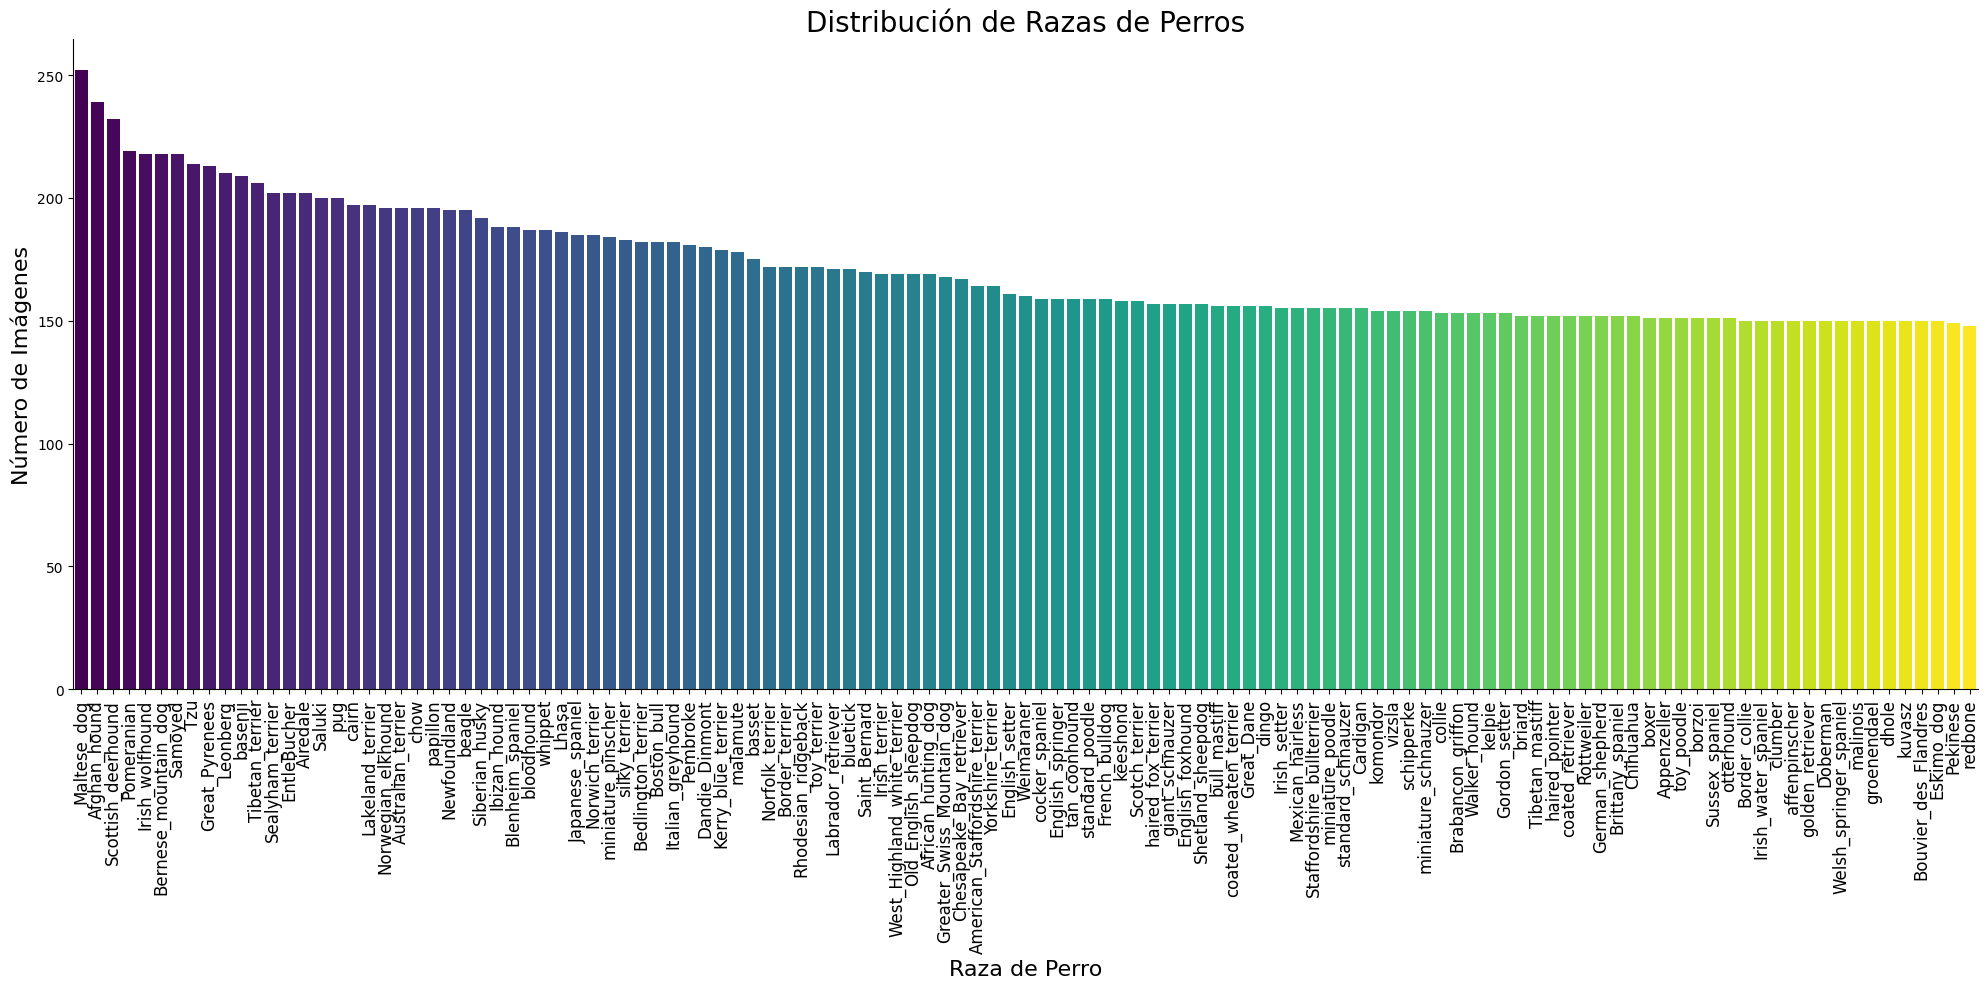

In [95]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Suponiendo que 'conteo_ordenado' es tu diccionario con el conteo de imágenes
razas = list(conteo_ordenado.keys())
conteos = list(conteo_ordenado.values())

# Crear gradación de colores a lo largo de las barras
colores = plt.cm.viridis(np.linspace(0, 1, len(razas)))

# Crear el gráfico de barras
plt.figure(figsize=(20, 10))  # Ajusta el tamaño según sea necesario
barras = plt.bar(razas, conteos, color=colores)

# Añadir un título y etiquetas a los ejes
plt.title('Distribución de Razas de Perros', fontsize=20)
plt.xlabel('Raza de Perro', fontsize=16)
plt.ylabel('Número de Imágenes', fontsize=16)

# Ajustar los límites del eje X para eliminar el espacio en blanco
plt.xlim(-0.5, len(razas) - 0.5)  # -0.5 establece la primera barra pegada al eje Y

# Rotar las etiquetas del eje X para mejor lectura
plt.xticks(rotation=90, fontsize=12)

# Remover las líneas de los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar el layout para asegurar que las etiquetas del eje X sean visibles
plt.tight_layout()

# Mostrar el gráfico
plt.show()

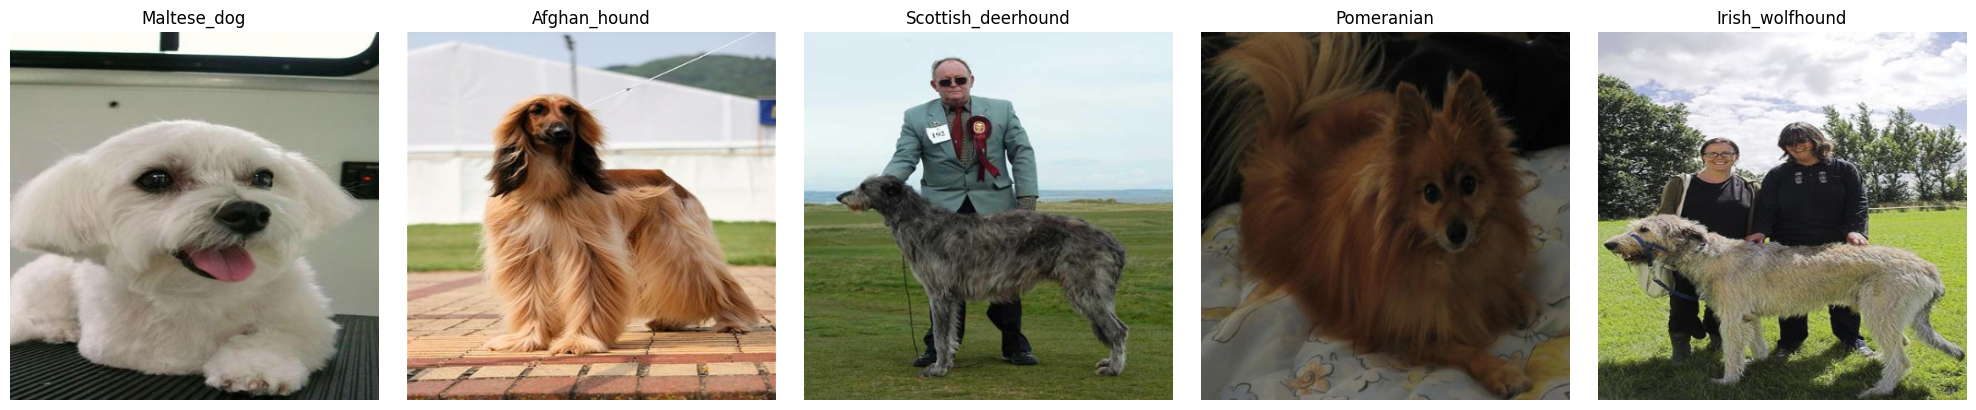

In [96]:
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from skimage.transform import resize

# Define la ruta al directorio que contiene imágenes de perros
PATH = './Stanford_Dogs_Dataset/images/Images/'

# Diccionario para almacenar el conteo de imágenes por raza
conteo_imagenes = {}

# Contar imágenes por raza
for raza in os.listdir(PATH):
    raza_path = os.path.join(PATH, raza)
    conteo_imagenes[raza] = len(os.listdir(raza_path))

# Ordenar y obtener las 5 razas con más imágenes
top_5_razas = sorted(conteo_imagenes, key=conteo_imagenes.get, reverse=True)[:5]

# Crear subplots para las 5 razas con más imágenes
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

for i, raza in enumerate(top_5_razas):
    raza_path = os.path.join(PATH, raza)
    images = os.listdir(raza_path)
    img_path = os.path.join(raza_path, random.choice(images))

    # Cargar y mostrar la imagen usando Matplotlib
    img = plt.imread(img_path)
    img = resize(img, (400, 400), anti_aliasing=True)

    axes[i].imshow(img)
    axes[i].set_axis_off()  # Desactiva el eje para una mejor visualización

    # Extraer el nombre de la raza del nombre de la carpeta
    raza_perro = raza.split('-')[-1]  # Extrae la parte después del guion
    axes[i].set_title(raza_perro, fontsize=12)

plt.tight_layout()
plt.show()

Cantidad disponible de razas de perro: 120


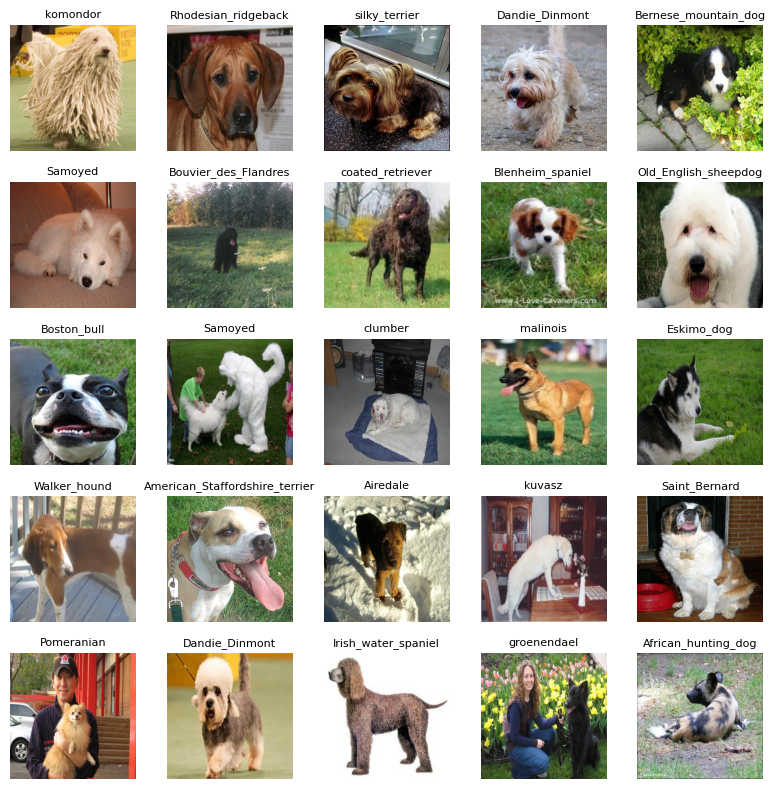

In [97]:
import random
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
import numpy as np

# Define la ruta al directorio que contiene imágenes de perros
PATH = './Stanford_Dogs_Dataset/images/Images/'

# Mostrar el conteo de imágenes de perros en el directorio
print(f'Cantidad disponible de razas de perro: {len(os.listdir(PATH))}')

# Crear subplots para mostrar imágenes aleatorias
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8))

# Iterar a través de los subplots y mostrar imágenes aleatorias de perros
for indx, axis in enumerate(axes.flatten()):
    PATH_TEMP = random.choice(os.listdir(PATH))
    # Obtener un índice aleatorio dentro del rango de imágenes disponibles
    rnd_indx = np.random.randint(0, len(os.listdir(PATH+'/'+PATH_TEMP)))

    # Cargar y mostrar la imagen usando Matplotlib
    images = os.listdir(PATH+'/'+PATH_TEMP+'/')
    img = plt.imread(PATH+'/'+PATH_TEMP + '/'+images[rnd_indx])
    # Redimensiona la imagen a un tamaño constante (por ejemplo, 400x400)
    img = resize(img, (400,400))

    imgplot = axis.imshow(img)
    axis.set_axis_off()  # Desactiva el eje para una mejor visualización

    # Extraer el nombre de la raza del nombre de la carpeta
    raza_perro = PATH_TEMP.split('-')[-1]  # Extrae la parte después del guion
    axis.set_title(raza_perro, fontsize=8)

plt.tight_layout()
plt.show()

### Preprocesamiento de imágenes

Aplicamos transformaciones a nuestras imágenes, redimensionándolas a 64x64 píxeles y aplicando cambios aleatorios en el color, rotación y volteo horizontal. Convertimos estas imágenes transformadas en tensores y las normalizamos. Cargamos estas imágenes en lotes de 32 desde un directorio y las mezclamos para añadir aleatoriedad. Este enfoque mejora la diversidad y el tamaño de nuestro conjunto de datos, aumentando la robustez de nuestro modelo.

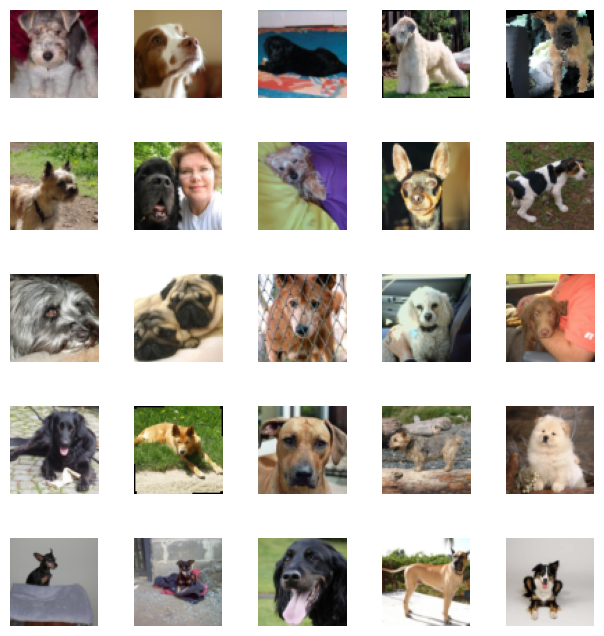

In [98]:
from torchvision import transforms, datasets
import torch
import numpy as np
import matplotlib.pyplot as plt

batch_size = 32
image_size = 64

# Define your transformations
random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(random_transforms, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Get a batch of images
imgs, labels = next(iter(train_loader))

# Convert the tensor to a numpy array and transpose the axes
imgs = imgs.numpy().transpose(0, 2, 3, 1)

# Denormalize the images
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
imgs = std * imgs + mean
imgs = np.clip(imgs, 0, 1)  # Ensure the values are clipped to the range [0, 1]

# Create a figure with subplots
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

# Display the images
for i in range(25):
    axs[i].imshow(imgs[i])
    axs[i].axis('off')

plt.show()

Resnet50

In [99]:
import tensorflow as tf

batch_size = 32
random_seed = 42

# Asegúrate de que fpath apunta al directorio correcto donde se encuentran tus imágenes
train_dataset = tf.keras.utils.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [100]:
random_seed = 42

val_dataset = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical")

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [101]:
class_names = train_dataset.class_names

names=[]
for name in class_names :
    names.append(name.split("-")[1])

print(names[:10]) # Printing some species

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound']


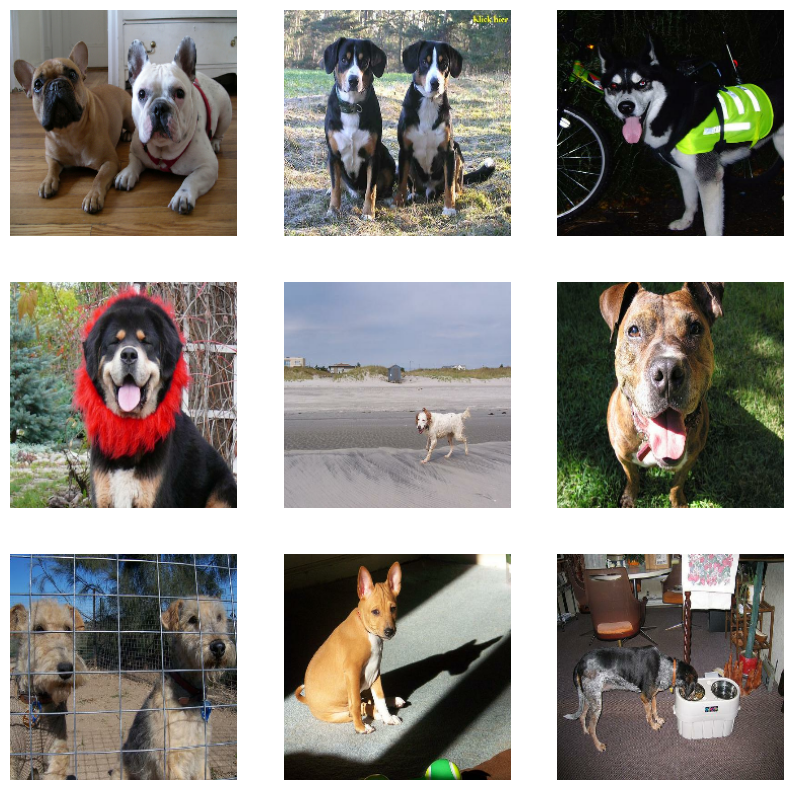

In [102]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [103]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

Model_URL = 'https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2'
model = Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    hub.KerasLayer(Model_URL),
    tf.keras.layers.Dense(120, activation="softmax")])

In [104]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"])

In [105]:
model.build((img_size, img_size, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1001)              25615849  
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 25736089 (98.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 25615849 (97.72 MB)
_________________________________________________________________


In [106]:
model_name = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5,
                                                 verbose = 1, restore_best_weights=True)

reduce_lr = tf._keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [107]:
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[checkpoint, reduce_lr])

Epoch 1/30


ValueError: ignored